![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Modeling with Random Forests

In this Notebook we will show you how to do exploratory data and train a Random Forest Model. You will learn how to tune your Random Forest model to achieve the best performance.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/ECCB-2024/1-Tutorial_RandomForest_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials

# Install additional packages
# %pip install ucimlrepo==0.0.7

### Imports

Let's start with importing all required Python packages.

In [2]:
# Load the required packages
import utils
import pickle
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.impute import KNNImputer
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from ucimlrepo import fetch_ucirepo 

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The Wisconsin Breast Cancer Dataset - A Radiomics Dataset

In this notebook, we will work with the **Wisconsin Breast Cancer dataset**, containing 569 samples of 212 malignant (encoded as 0) and 357 benign (encoded as 1) tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_breastcancer.png?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/code/midouazerty/breast-cancer-prediction-99)

In [4]:
# Load the data
data_fetched = load_breast_cancer(as_frame=True)

We can have a look at the description of the dataset with `print(data_breastcancer['DESCR'])`.  
Before we can start analysing the dataset, we have to retrieve the features and target variable and we will remap the target encoding to 0_control and 1_cancer, which is the standard encoding for control/cancer.

In [5]:
# Get the dataframe
data_breastcancer = data_fetched.frame

# Move target column to front
col_target = "target"
col_features = data_breastcancer.columns.drop(col_target).to_list()
data_breastcancer = data_breastcancer[[col_target]+col_features]

# Encode target feature
data_breastcancer['target'] = data_breastcancer['target'].map({1: '0_Control', 0: '1_Cancer'})

### Exploratory Data Analysis

Exploratory data analysis is a first important step to get an understanding of the data and to identify patterns and problems in the data.  
First, we will check how many samples and variables our dataset has and inspect the first few lines of our dataset.

In [6]:
# Inspect the data
print(f"The dataset has {data_breastcancer.shape[1] - 1} variables that describe {data_breastcancer.shape[0]} patients.")
print(f"We have {data_breastcancer.select_dtypes(exclude='object').shape[1]} numerical and {data_breastcancer.select_dtypes(include='object').shape[1] - 1} categorical features.")
print(f"We have {len(data_breastcancer[data_breastcancer['target'] == '0_Control'])} ({round(len(data_breastcancer[data_breastcancer['target'] == '0_Control']) / len(data_breastcancer) * 100, 2)} %) control and {len(data_breastcancer[data_breastcancer['target'] == '1_Cancer'])} ({round(len(data_breastcancer[data_breastcancer['target'] == '1_Cancer']) / len(data_breastcancer) * 100, 2)} %) cancer patients.")

The dataset has 30 variables that describe 569 patients.
We have 30 numerical and 0 categorical features.
We have 357 (62.74 %) control and 212 (37.26 %) cancer patients.


In [7]:
print("\nHere are the first few lines of our dataset:")
data_breastcancer.head()


Here are the first few lines of our dataset:


,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1_Cancer,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1_Cancer,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1_Cancer,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1_Cancer,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1_Cancer,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Next, we check if any values are missing:

In [8]:
print(data_breastcancer.isnull().sum())

target                     0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


And last, we inspect how our variables are distributed:

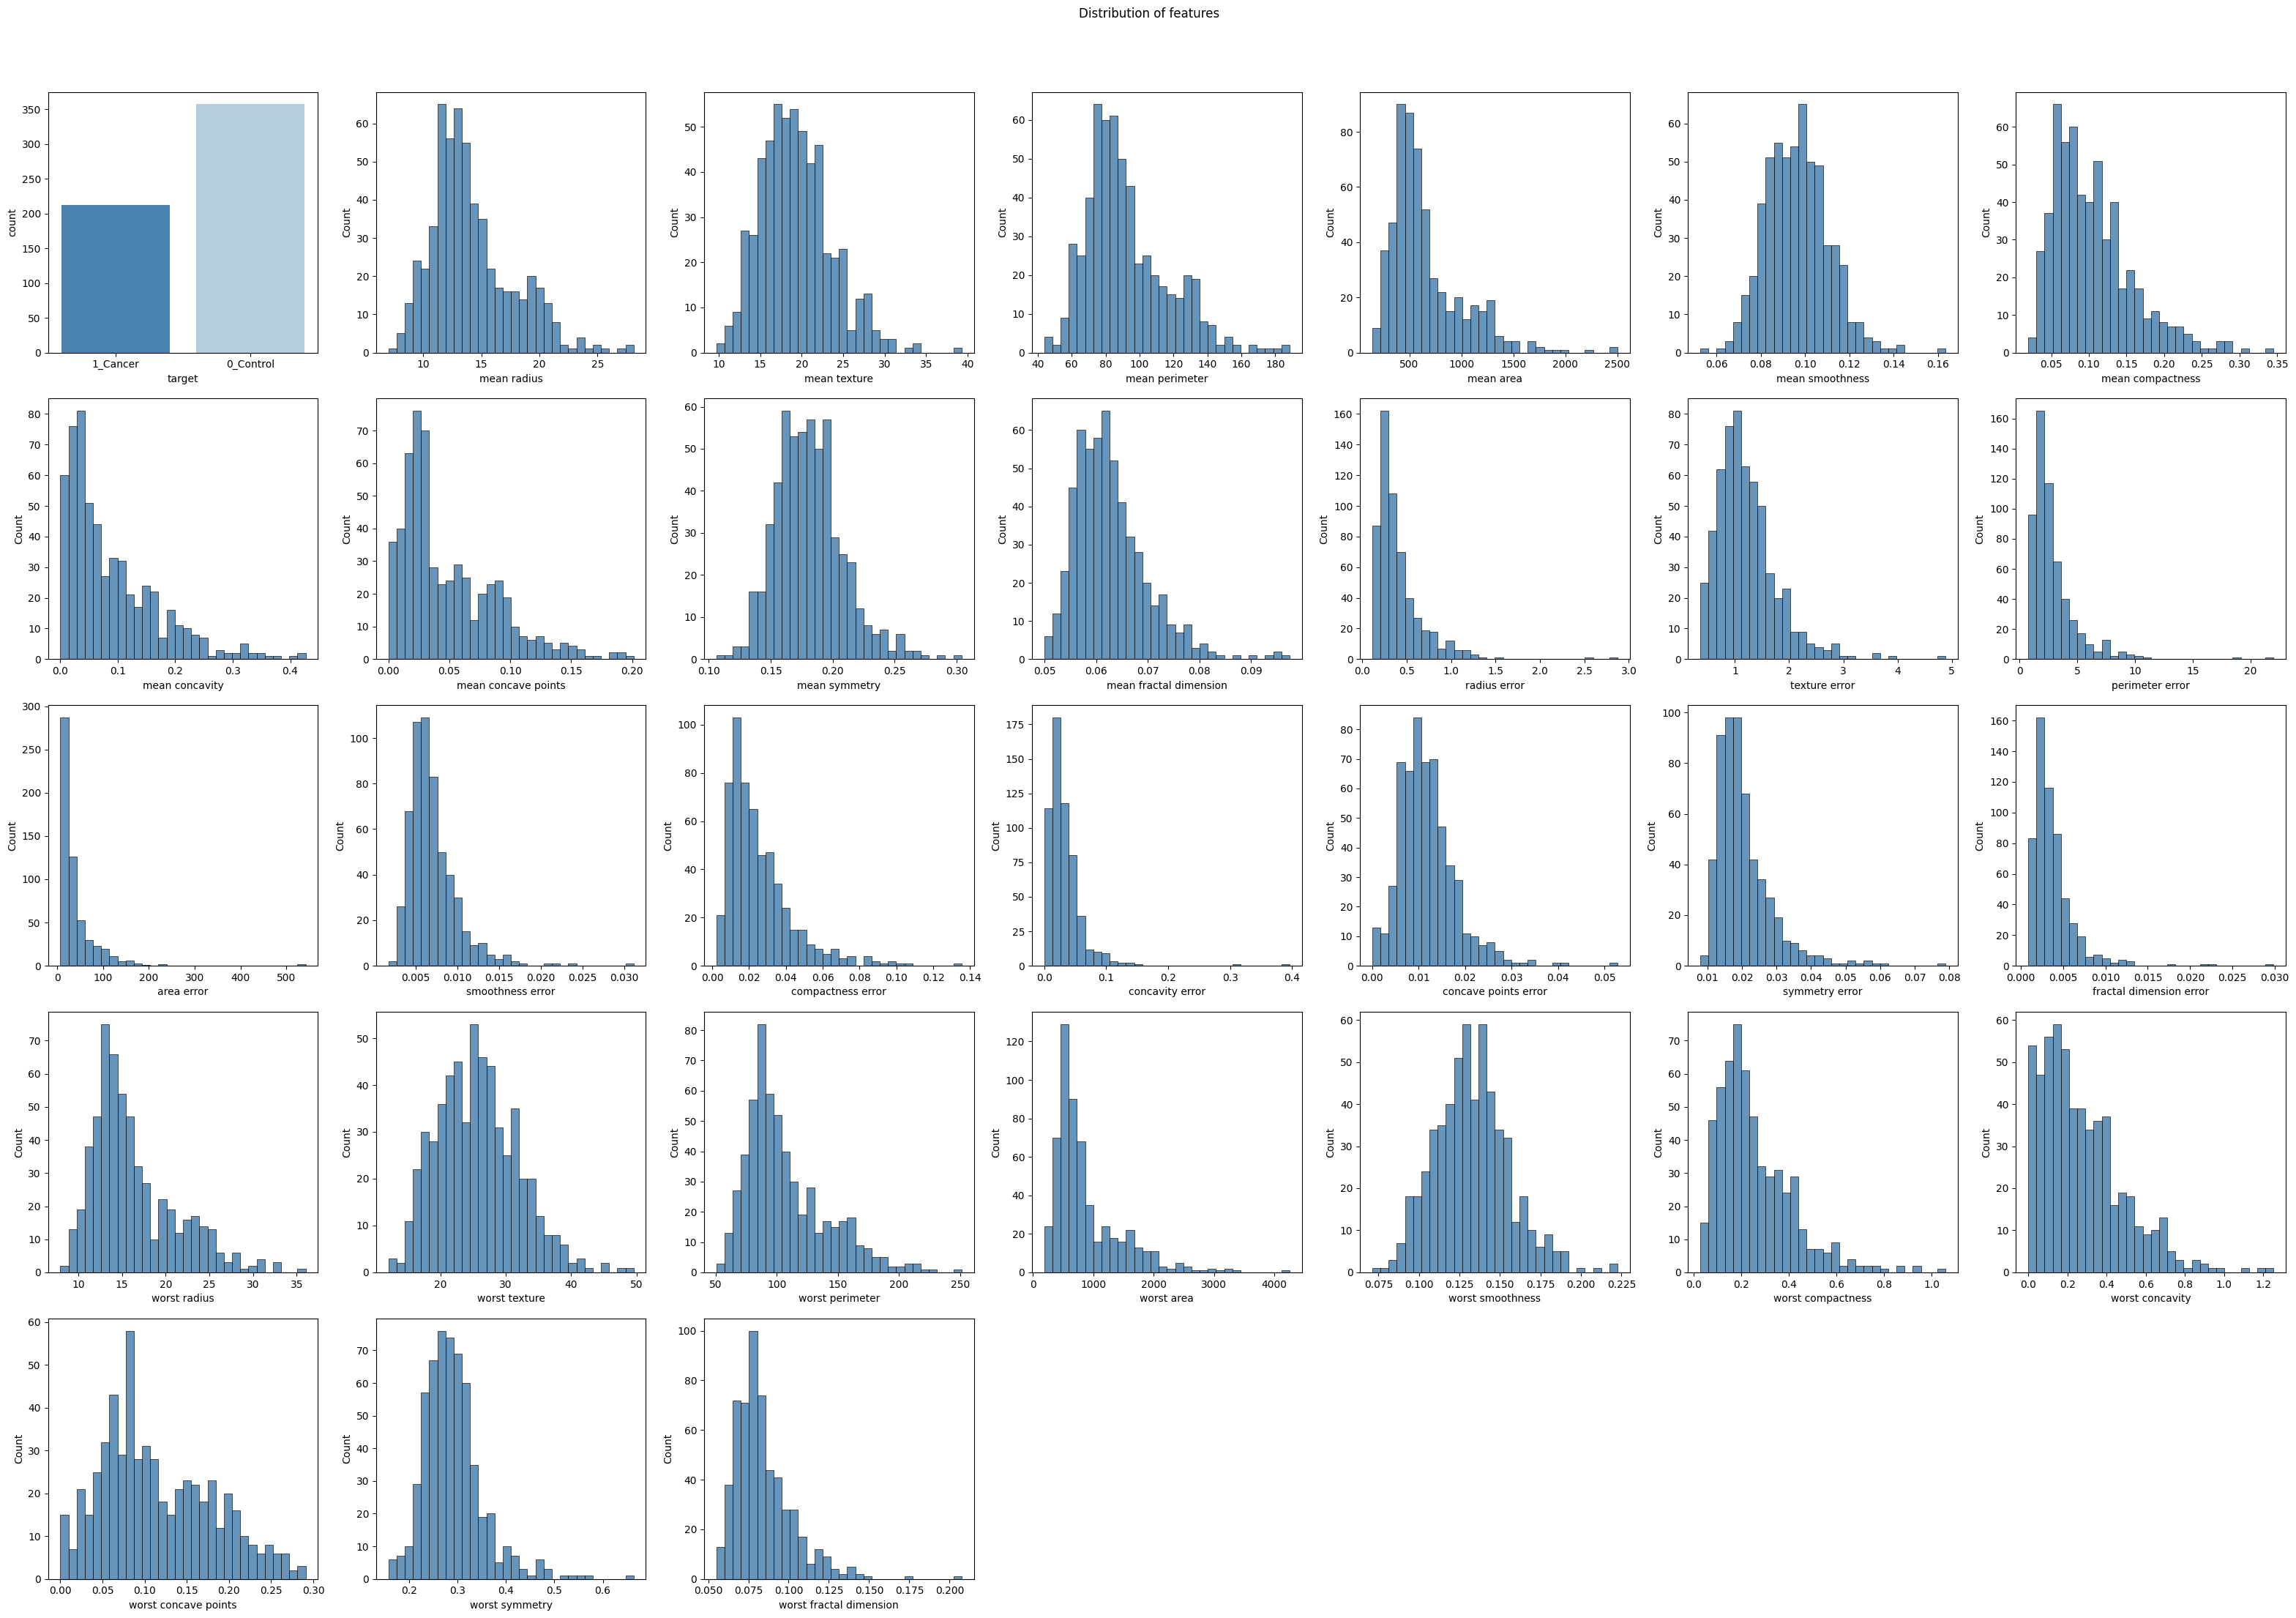

In [9]:
utils.plot_distributions(dataset=data_breastcancer, ncols=7)

<font color='green'>

#### Question 1: What conclusions can be drawn from the exploratory data analysis?

<font color='grey'>

#### Your Answer: 



In [10]:
data = data_breastcancer

--------

## Random Forest Models

**Note: Please visit our [Introduction to Random Forest Models](https://xai-tutorials.readthedocs.io/en/latest/_ml_basics/random_forest.html) to get more theoretical background information on the Random Forest algorithm.**

In the subsequent sections we will show you how to train a Random Forest model for a binary classification problem. But before we start training our Random Forest model, try to answer the following questions:

<font color='green'>

#### Question 2: What are model hyperparameters and why do we have to tune them?

<font color='grey'>

#### Your Answer: 



### Hyperparameters of Random Forest

The hyperparameters of the model are configured up-front and are provided by the caller of the model before the model is trained. They guide the learning process for a specific dataset and hence, they are very important for training a machine learning model. 

Some important hyperparameters for Random Forest models:

- `n_estimators` = number of trees in the model
- `criterion` = a function to measure the quality of the split
- `max_depth` = maximal depth of the tree (the longest path between the root node and the leaf node)
- `max_sample` = which fraction of the original dataset is given to each tree in the forest
- `max_features` = maximum number of features to consider when doing a split

The full list of hyperparemeters of the Random Forest models can be found in the scikit-learn documentation.

<font color='green'>

#### Question 3: How do we find the best hyperparameters?

<font color='grey'>

#### Your Answer: 



Now, that we learned about the hyperparameters of Random Forest and had a look at the choices we have for the Random Forest algorithm, it is time to choose the optimal hyperparameters for our model. We will objectively search through different values for Random Forest hyperparameters and choose the set of hyperparameters that results in the model with the best performance on a given validation set. To do this, we will define a search space as a grid of hyperparameter values and evaluate every position in the grid. This hyperparameter optimization technique is called **grid-search**. To evaluate the grid-search results, we can use **n-fold cross validation**. The n-fold cross validation strategy will split the training data into n folds and then train the model on n-1 folds and test it's performance on the nth fold, iterating through each fold as validation fold once. Hence, the reported score is the average score across n validation sets.

The grid-search technique searches through every combination of the hyperparameters you define. Hence, the run time can increase very fast and it should be something to take into account when training the model. For the sake of example, in this notebook we will define a rather small grids of hyperparameters.

--------

## Training a Random Forest Model for Binary Classification

First, we will split the data into a **train and test set**, such that the model does not use all the available information for training. That way, we can also check the performance on previously unseen data, mirroring the most probable practical use case.

In [11]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values.
# Hence, we will first separate the target and feature columns.
X = data[col_features]
y = data[col_target]

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=seed)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(f'Number of training samples: {len(X_train.index)} with {sum(y_train=="0_Control")} control and {sum(y_train=="1_Cancer")} cancer samples.')
print(f'Number of training samples: {len(X_test.index)} with {sum(y_test=="0_Control")} control and {sum(y_test=="1_Cancer")} cancer samples.')

Number of training samples: 455 with 285 control and 170 cancer samples.
Number of training samples: 114 with 72 control and 42 cancer samples.


Remark: generally, it is required to standardize the features before model training. To avoid information leakage between train and test set through the standardization procedure, the Standardizer should be fit on the training set and then useed to transform train, validation and test set. However, standardization is not necessary for tree-based methods, hence we don't standardize our features for the Random Forest model.

Next, we define the hyperparameter grid we want to use for the grid-search. Feel free to change the grid based on your acquired knowledge and research on Random Forest hyperparameters! Just take care about the computation time for now. 

In [12]:
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [5, 10, 20], 
            'max_samples': [0.8],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2'],
            'class_weight': ['balanced', 'balanced_subsample']
}

Now we will start the training process. First, we define an instance of the `RandomForestClassifier`. Then, we run the `GridSearchCV` with the 5-fold cross validation using the grid we defined above. 

In [13]:
# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=3)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=3, oob_score=True,
                                              random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.8],
                         'n_estimators': [100, 1000]},
             verbose=1)

Then we can check how well the best model performed during cross-validation and which hyperparameters lead to the best reults.

In [14]:
# Check the results
print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_*100, 2)}% accuracy and the parameters of best prediction model are:')
print(gridsearch_classifier.best_params_)

The mean cross-validated score of the best model is 95.82% accuracy and the parameters of best prediction model are:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 100}


The model with the best hyperparameters is saved as the _best_estimator__ in the GridSearchCV instance.  
Note, that the returned model is a Random Forest Classifier that was refit using the best found parameters on the whole training dataset. 

We can estimate the training, validation and test score, using the training, OOB and test set, respectively.

In [15]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the OOB data?
print(f'Model Performance on OOB data: {round(rf.oob_score_*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 100.0 % accuracy.
Model Performance on OOB data: 95.82 % accuracy.
Model Performance on test data: 95.61 % accuracy.


Great, now you trained your Random Forest model! And it generalized with a high accuracy!  

*Note: if your classes are strongly imbalanced, then it is NOT recommendable to use the simple accuracy as a performance score. If all classes of the imbalanced dataset are equally important, using the macro accuracy or balanced accuracy is recommended as it treats all classes equally.*

Since we have a slight imbalance in our dataset, we addtionally check balanced accuracy score, to ensure that our model generalizes properly.

In [16]:
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, rf.predict(X_train))*100,2)} % balanced accuracy.')
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, rf.predict(X_test))*100,2)} % balanced accuracy.')

Model Performance on training data: 100.0 % balanced accuracy.
Model Performance on test data: 94.05 % balanced accuracy.


Let's now save the model in a ``pickle`` file, such that we can load the trained model into other notebooks later on.

In [17]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, rf]

with open('../models/model_rf_breastcancer.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

--------

## Feature Correlation

To demonstrate the influence of correlated features on an explainability analysis, we will train a second Random Forest Classifier on a reduced feature set, which does not contain highly correlated features anymore. One way to select features that are uncorrelated is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster (taken from [sklearn documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features)). Therefore, we first plot a correlation heatmap the degree of correlation in our dataset:

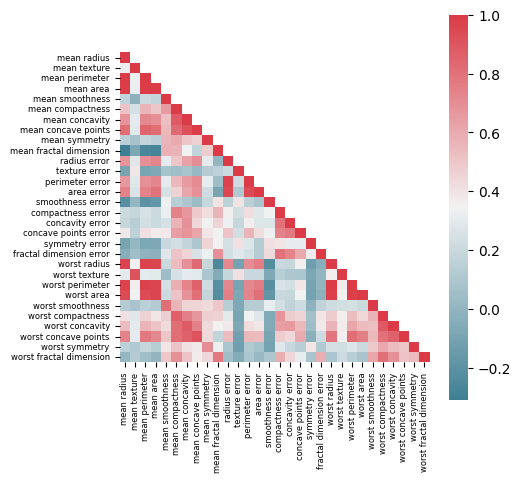

In [18]:
utils.plot_correlation_matrix(X, figsize=(5,5), annot=False, labelsize=6)

We can see in the heatmap above that we have many highly correlated features in our dataset. To select a set of features, which are uncorrelated, we plot the hierarchical clustering and manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep.

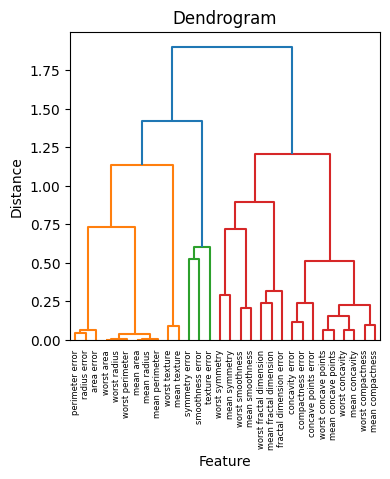

In [19]:
# compute spearman correlation and make sure the matrix is symmetric
corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before 
# performing hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

utils.plot_dendrogram(dist_linkage, X.columns.to_list(), figsize=(4, 4), leaf_font_size=6)

Looking at the dendrogram above, we choose a threshold of distance 1, for the grouping of features and randomly select the first feature in each cluster for our uncorrelated feature set.

In [20]:
thr_cluster = 1

cluster_ids = hierarchy.fcluster(dist_linkage, thr_cluster, criterion="distance")
#cluster_id_to_feature_ids = defaultdict(list)

#for idx, cluster_id in enumerate(cluster_ids):
#    cluster_id_to_feature_ids[cluster_id].append(idx)

#selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = np.unique([np.where(cluster_ids == cluster_id)[0][0] for cluster_id in np.unique(cluster_ids)])
selected_features_names = X.columns[selected_features].to_list()

print(f"The selected features are: {selected_features_names}")

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

The selected features are: ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'texture error']


Once we have selected our set of uncorrelated features, we train our Random Forest Classifier with hyperparameter tuning using cross-validation as shown above.

In [21]:
# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=3)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_train_sel, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=3, oob_score=True,
                                              random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.8],
                         'n_estimators': [100, 1000]},
             verbose=1)

In [22]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, rf.predict(X_train_sel))*100,2)} % balanced accuracy.')
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, rf.predict(X_test_sel))*100,2)} % balanced accuracy.')

Model Performance on training data: 98.36 % balanced accuracy.
Model Performance on test data: 89.38 % balanced accuracy.


Let's now save the model in a ``pickle`` file, such that we can load the trained model into other notebooks later on.

In [23]:
# Save the model with joblib
data_and_model = [X_train_sel, X_test_sel, y_train, y_test, rf]

with open('../models/model_rf_breastcancer_sel.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

--------

## Extra Material: The UCI Cervical Cancer Dataset

**In this extra material, we will show you the importance of the exploratory data analysis and choice of correct evaluation metric.**  
We will work with the UCI Cervical Cancer dataset, containing medical records of 858 patients with 803 healthy patients (class 0) and 55 patients with biopsy indicating cervical cancer (class 1). Diagnosis outcome is described by 28 features covering demographic information, habits, and historic medical records (for more details please see descrption [here](https://archive.ics.uci.edu/dataset/383/cervical+cancer+risk+factors)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_cervicalcancer.jpg?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification)

First, let's load and process the data into the correct format.

In [24]:
# Load the data
data_fetched = fetch_ucirepo(id=383) 
data_cervicalcancer = data_fetched.data.features

# Drop unnecessary columns (alternative target columns for either different diagnosis (DX) or tests)
data_cervicalcancer = data_cervicalcancer.drop(columns=['Citology', 'Schiller', 'Hinselmann', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'])

# Define which features are categorical
features_categorical = ['Biopsy','Smokes','Hormonal Contraceptives','IUD','STDs','STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS','STDs:HIV','STDs:Hepatitis B','STDs:HPV']
data_cervicalcancer[features_categorical] = data_cervicalcancer[features_categorical].astype('category')

# Move target column to front
cols = data_cervicalcancer.columns.tolist()  
data_cervicalcancer = data_cervicalcancer[[cols[-1]] + cols[:-1]]

# Move target column to front
col_target = "Biopsy"
col_features = data_cervicalcancer.columns.drop(col_target).to_list()
data_cervicalcancer = data_cervicalcancer[[col_target]+col_features]

# Convert Biopsy column to categorical labels
data_cervicalcancer['Biopsy'] = data_cervicalcancer['Biopsy'].map({0: '0_Control', 1: '1_Cancer'})

### Exploratory Data Analysis

Let's check how many samples and variables our dataset has and inspect the first few lines of our dataset:

In [25]:
# Inspect the data
print(f"The dataset has {data_cervicalcancer.shape[1] - 1} variables that describe {data_cervicalcancer.shape[0]} patients.")
print(f"We have {data_cervicalcancer.select_dtypes(exclude='category').shape[1]} numerical and {len(data_cervicalcancer.select_dtypes(include='category').columns) - 1} categorical features.")
print(f"We have {len(data_cervicalcancer[data_cervicalcancer['Biopsy'] == '0_Control'])} ({round(len(data_cervicalcancer[data_cervicalcancer['Biopsy'] == '0_Control']) / len(data_cervicalcancer) * 100, 2)} %) control and {len(data_cervicalcancer[data_cervicalcancer['Biopsy'] == '1_Cancer'])} ({round(len(data_cervicalcancer[data_cervicalcancer['Biopsy'] == '1_Cancer']) / len(data_cervicalcancer) * 100, 2)} %) cancer patients.")

The dataset has 28 variables that describe 858 patients.
We have 12 numerical and 16 categorical features.
We have 803 (93.59 %) control and 55 (6.41 %) cancer patients.


In [26]:
print("\nHere are the first few lines of our dataset:")
data_cervicalcancer.head(5)


Here are the first few lines of our dataset:


,Biopsy,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),...,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis
0,0_Control,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
1,0_Control,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
2,0_Control,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,0_Control,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
4,0_Control,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN


Next, we check if any values are missing:

In [27]:
print(data_cervicalcancer.isnull().sum())

Biopsy                                  0
Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                          

And last, we inspect how our variables are distributed:

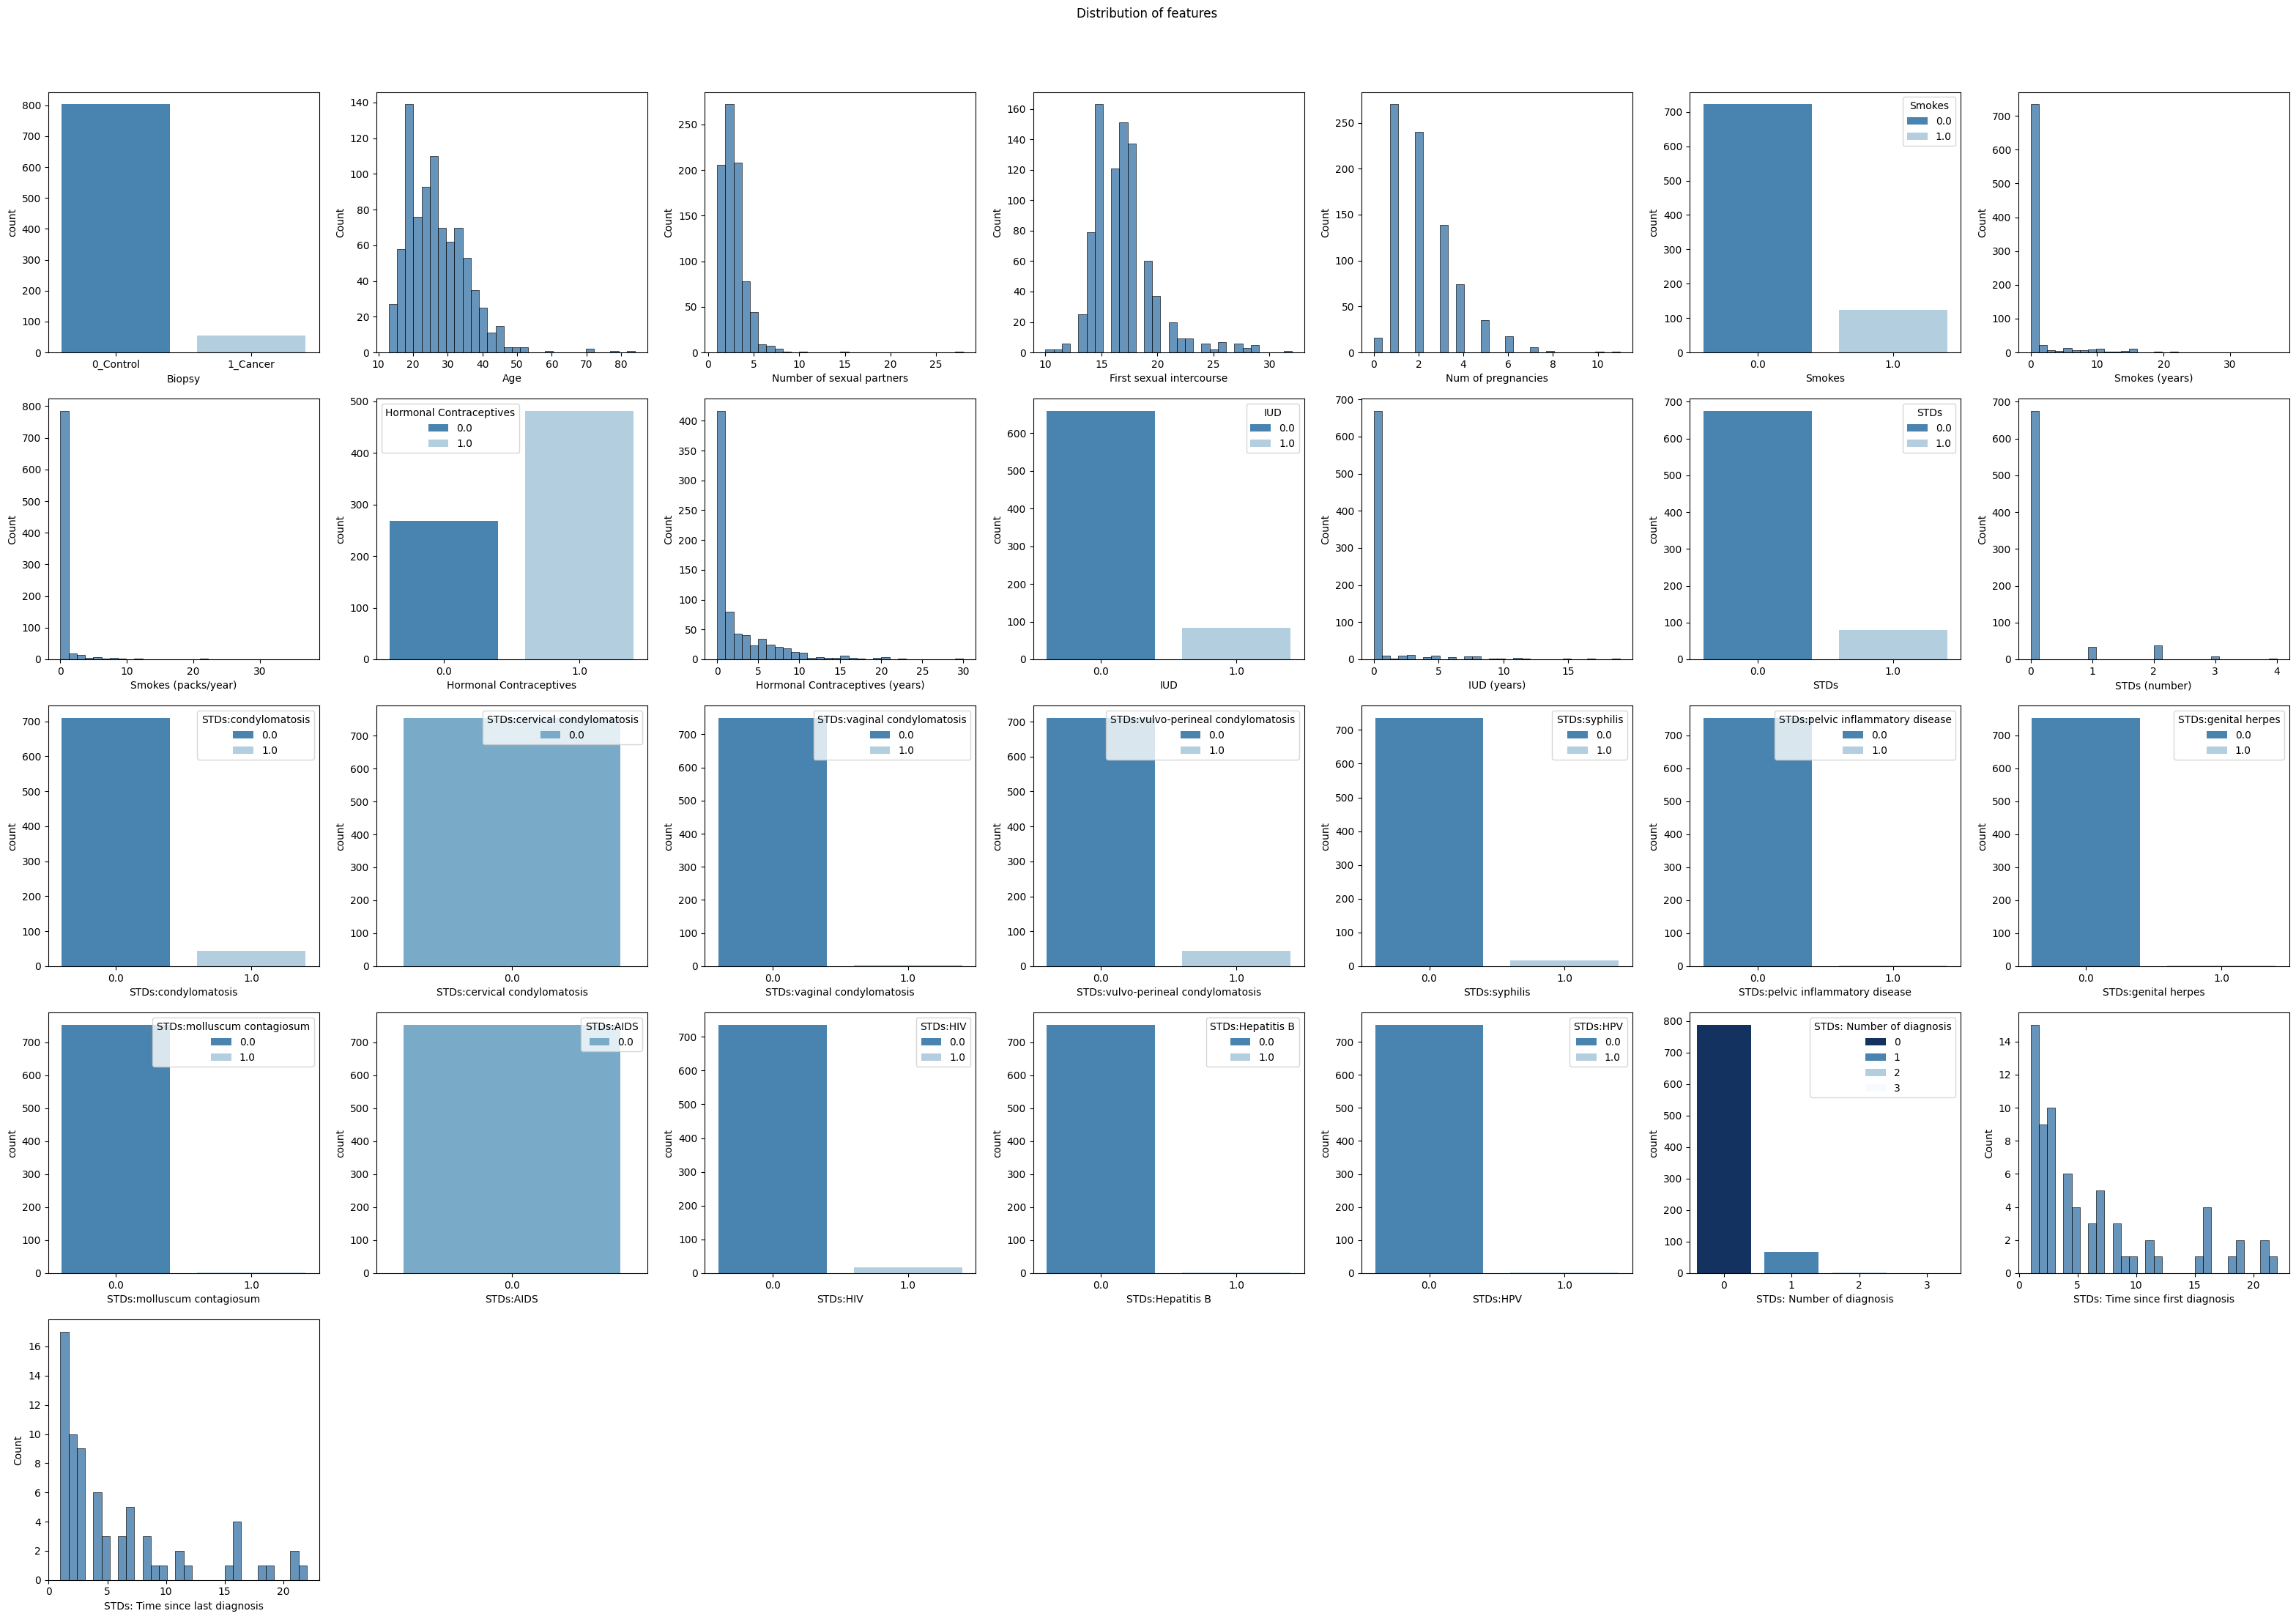

In [28]:
utils.plot_distributions(dataset=data_cervicalcancer, ncols=7)

By analysing the results of the EDA we can conclude:

- we have a high class imbalance in the dataset
- we have missing values in the dataset we need to take care of
- we need to encode categorical features for the classification model

### Data Preprocessing
#### Handling of Missing Values 

Based on what we saw in the explorative analysis above, we need to do some preprocessing steps before we start training the model. First, we need to take care of the missing values. There are different options how one can deal with this problem and the strategy one chooses depends heavily on the dataset and the context we are in.

In this dataset, we cannot handle all missing values with one approach but choose accordingly:

- the features "STDs: Time since first diagnosis" and "STDs: Time since last diagnosis" have more than 90% missing values, hence we remove those features entirely
- the features "STDs:xx" have more than 10% missing values, however, removing them would lead to a loss of ~20% "cancer" patients. Since the "cancer" class is already underrepresented in our dataset, we want to avoid loosing too many samples of this class. On the other hand, we have to consider that imputing those values might be difficult since we can see from the distribution plots that we have a high imbalance in no STD vs STD. This is why we decide to drop the single "STDs:xx" value and only keep the aggregation features "STDs" and STDs (number). Since we have more balanced data here, it's more reliable to impute the missing values of those features.
- remaining features: for the ramining features we impute the missing values to keep all "cancer" class samples in the dataset. We choose the KNN Imputer as it is more accurate than a simple mean/median/most_frequent imputer. In order to use the KNN imputer, we have to remove the target variable "biopsy" from the dataset beforehand as this would influence in an overly optimistic way our classification model.

In [29]:
# remove features we can't reliably impute
std_time = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']
std_xx = ['STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis','STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease','STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS','STDs:HIV','STDs:Hepatitis B','STDs:HPV']

data_cervicalcancer = data_cervicalcancer.drop(columns=std_time)
data_cervicalcancer = data_cervicalcancer.drop(columns=std_xx)

In [30]:
# impute missing values for remaining features using KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="distance").set_output(transform="pandas")

data_cervicalcancer_imp = data_cervicalcancer.drop(columns=["Biopsy"])
data_cervicalcancer_imp = imputer.fit_transform(data_cervicalcancer_imp)
data_cervicalcancer_imp["Biopsy"] = data_cervicalcancer["Biopsy"]

print(data_cervicalcancer_imp.isnull().sum())

Age                                0
Number of sexual partners          0
First sexual intercourse           0
Num of pregnancies                 0
Smokes                             0
Smokes (years)                     0
Smokes (packs/year)                0
Hormonal Contraceptives            0
Hormonal Contraceptives (years)    0
IUD                                0
IUD (years)                        0
STDs                               0
STDs (number)                      0
STDs: Number of diagnosis          0
Biopsy                             0
dtype: int64


Since we also imputed missing values for categorical features, we need to convert the imputed values to categories, simply by rounding the imputed values.

In [31]:
features_categorical = [col for col in features_categorical if col in data_cervicalcancer_imp.columns and col != "Biopsy"]
data_cervicalcancer_imp[features_categorical] = data_cervicalcancer_imp[features_categorical].round()
data_cervicalcancer_imp[features_categorical] = data_cervicalcancer_imp[features_categorical].replace({0: 'No', 1: 'Yes'})

#### Encoding of categorical variables

Categorical features need to be encoded, i.e. turned into numerical data. This is essential because most machine learning models can only interpret numerical data and not data in a text form. As with many data preprocessing steps, there are multiple strategies one can apply to encode the categorical features. 

Here, we will use a simple **dummy encoding** for the categorical features, which will transform the categorical feature values into one-hot encoded vectors. Remeber that our goal is to predict the Biopsy outcome and hence, our target variable *"Biopsy"* does not need to be encoded, because it will be interepreted as different classes by the Random Forest Classifier.

In [32]:
# preprocess categorical features such that they can be used for the RF model
data_cervicalcancer_encoded = pd.get_dummies(data_cervicalcancer_imp, columns=features_categorical, prefix=features_categorical, drop_first=True)
col_features = data_cervicalcancer_encoded.columns.drop(col_target).to_list()

Dataset before encoding:

In [33]:
data_cervicalcancer_imp.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs: Number of diagnosis,Biopsy
0,18.0,4.0,15.000000,1.0,No,0.0,0.0,No,0.0,No,0.0,No,0.0,0.0,0_Control
1,15.0,1.0,14.000000,1.0,No,0.0,0.0,No,0.0,No,0.0,No,0.0,0.0,0_Control
2,34.0,1.0,24.015132,1.0,No,0.0,0.0,No,0.0,No,0.0,No,0.0,0.0,0_Control
3,52.0,5.0,16.000000,4.0,Yes,37.0,37.0,Yes,3.0,No,0.0,No,0.0,0.0,0_Control
4,46.0,3.0,21.000000,4.0,No,0.0,0.0,Yes,15.0,No,0.0,No,0.0,0.0,0_Control


and after encoding categorical features:

In [34]:
data_cervicalcancer_encoded.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,Biopsy,Smokes_Yes,Hormonal Contraceptives_Yes,IUD_Yes,STDs_Yes
0,18.0,4.0,15.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Control,False,False,False,False
1,15.0,1.0,14.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Control,False,False,False,False
2,34.0,1.0,24.015132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0_Control,False,False,False,False
3,52.0,5.0,16.000000,4.0,37.0,37.0,3.0,0.0,0.0,0.0,0_Control,True,True,False,False
4,46.0,3.0,21.000000,4.0,0.0,0.0,15.0,0.0,0.0,0.0,0_Control,False,True,False,False


Note, that the option ``drop_first=True`` leads to k-1 dummies out of k categorical levels by removing the first level. However, it still contains the same amount of information. 

In [35]:
data = data_cervicalcancer_encoded

### Training a Random Forest Model 

Let's now train our Random Forest model on the pre-processed dataset. As we have seen before, we need to split our data into a train and test split to be able to measure the generalizeability of our trained model. Since we have a high class imbalance we can't do a simple random train - test split but have do a stratified train - test split to garantuee that we have enough instances of the underrepresented class both sets. This can be achieved by specifying the *stratify* parameter for the `train_test_split` function. This parameters ensures tha the data is split in a stratified fashion, using the class labels.

In [36]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values.
# Hence, we will first separate the target and feature columns.
X = data[col_features]
y = data[col_target]

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=seed, stratify=y)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(f'Number of training samples: {len(X_train.index)} with {sum(y_train=="0_Control")} control and {sum(y_train=="1_Cancer")} cancer samples.')
print(f'Number of training samples: {len(X_test.index)} with {sum(y_test=="0_Control")} control and {sum(y_test=="1_Cancer")} cancer samples.')

Number of training samples: 686 with 642 control and 44 cancer samples.
Number of training samples: 172 with 161 control and 11 cancer samples.


Next, we define the hyperparameter grid, we want to want to use for the grid-search and then start the training process with hyperparameter search.  
As for the train - test split, we have to ensure that during the hyperparameter search, where we use cross-validation for evaluation of the hyperparameter set, the train and validation sets are stratified and contains instances of the underrepresented class. This can be done by using `StratifiedKFold` as *cv* parameter in the `GridSearchCV` search.  
In addition, we have to adapt our scoring metric from a simple *accuracy* to the *balanced_accuracy*, which weights each class equally, i.e. computes the accuracy independently for each class and then takes the average. Using the balanced accuracy avoids getting an overoptimistic performance for a model that underperforms on the underrepresented class.

In [37]:
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [5, 10, 20], 
            'max_samples': [0.8],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2'],
            'class_weight': ['balanced', 'balanced_subsample']
}

# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=3)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=stratified_kfold, scoring='balanced_accuracy', verbose=1)
gridsearch_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=3, oob_score=True,
                                              random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.8],
                         'n_estimators': [100, 1000]},
             scoring='balanced_accuracy', verbose=1)

Let's now have a look at the training, validation and test accuracy.

In [38]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the OOB data?
print(f'Model Performance on OOB data: {round(rf.oob_score_*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 98.98 % accuracy.
Model Performance on OOB data: 93.44 % accuracy.
Model Performance on test data: 94.19 % accuracy.


Great, our model achieves a very high accuracy for both train and test set, so it also generalizes well to unseen data, doesn't it?.  
But wait, since our classes are highly imbalanced we should use the simple accuracy as a performance score, right?

Instead we want to use the balanced accuracy (or macro accuracy) which treats all classes equally:

In [39]:
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, rf.predict(X_train))*100,2)} % accuracy.')

Model Performance on training data: 95.22 % accuracy.


In [40]:
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, rf.predict(X_test))*100,2)} % accuracy.')

Model Performance on test data: 54.55 % accuracy.


In [41]:
# from sklearn.metrics import classification_report
# print(classification_report(y_train, rf.predict(X_train)))
# print(classification_report(y_test, rf.predict(X_test)))

Using the balanced accuracy shows us that the model performs very well on the training set but very poorly on the test set, i.e. fails to generalize to unseen data. This behaviour is a sign of model **overfitting**, where the model learns the training data too well, to the point that it captures not only the underlying patterns but also the noise and random fluctuations in the data. 